In [1]:
import netCDF4 as nc
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "/data/SO2/SO24/ANDY/SOHI/Utils")

In [3]:
import SOhi_Toolbox as tb
import Andy


NCWriter_v1 - updated October 17
SOhi2nc v1.1 - Last updated Mar 23, 2023. -Andy


In [4]:
cube = nc.Dataset("/data/SO2/SO24/ANDY/SOHI/Data/Obs_Climatology/ISMIP6/obs_temperature_1995-2017_8km_x_60m.nc")
XC = cube['lon'][:] 
YC = cube['lat'][:]
cube = nc.Dataset("/data/SO2/SO24/ANDY/SOHI/Data/Obs_Climatology/ISMIP6/bedmap2_8km.nc")
GI = cube['icemask_grounded'][:]
IS = cube['icemask_shelves'][:]

In [5]:
def find(YC, XC, lat, lon):
    i1 = (XC - lon)**2
    i2 = (YC - lat)**2
    i3 = i1 + i2
    if i3.min() > 0.5:
        return None, None
    where = np.where(i3 == i3.min())
    return where[0][0], where[1][0] ## Return row, column

In [6]:
mask = np.load('/data/SO2/SO24/ANDY/SOHI/Notebooks/1_SOHI_Eval/99_HeatTransport_Eval/data_stair_stepping/SOHI_mask.npy')
BATH, X, Y = Andy.loads.sohi_meta('bathymetry')

In [7]:
### map mask to new grid
cs_mask = np.zeros(YC.shape)

for i in tqdm(range(cs_mask.shape[0])):
    for j in range(cs_mask.shape[1]):
        lat = YC[i, j]
        lon = XC[i, j]
        
        idy = np.argmin(abs(lat - Y))
        idx = np.argmin(abs(lon - X))
        
        cs_mask[i, j] = mask[idy, idx]

100%|█████████████████████████████████████████████████████████| 761/761 [00:10<00:00, 74.70it/s]


In [8]:
np.save('1k_mask.npy', cs_mask)

In [19]:
ICESHELVES = np.load(f'/data/SO2/SO24/ANDY/SOHI/Notebooks/1_SOHI_Eval/07_ISMIP_Comparison/maps/ICESHELVES.npy')
BATH = np.load(f'/data/SO2/SO24/ANDY/SOHI/Notebooks/1_SOHI_Eval/07_ISMIP_Comparison/maps/SOHI_Bathymetry.npy')

In [20]:
m1 = BATH == 0
m2 = ICESHELVES != 0
m3 = np.logical_or(m1, m2)

m1[650:, 0:200] = 0
m1[:98, :] = 0
m1[:, :60] = 0

In [21]:
density = np.load('data/density/distribution_summer.npy') + np.load('data/density/distribution_winter.npy')
density[density ==0] = np.nan
density[np.isnan(cs_mask)] = np.nan

In [22]:
cs_mask[BATH==0] = np.nan

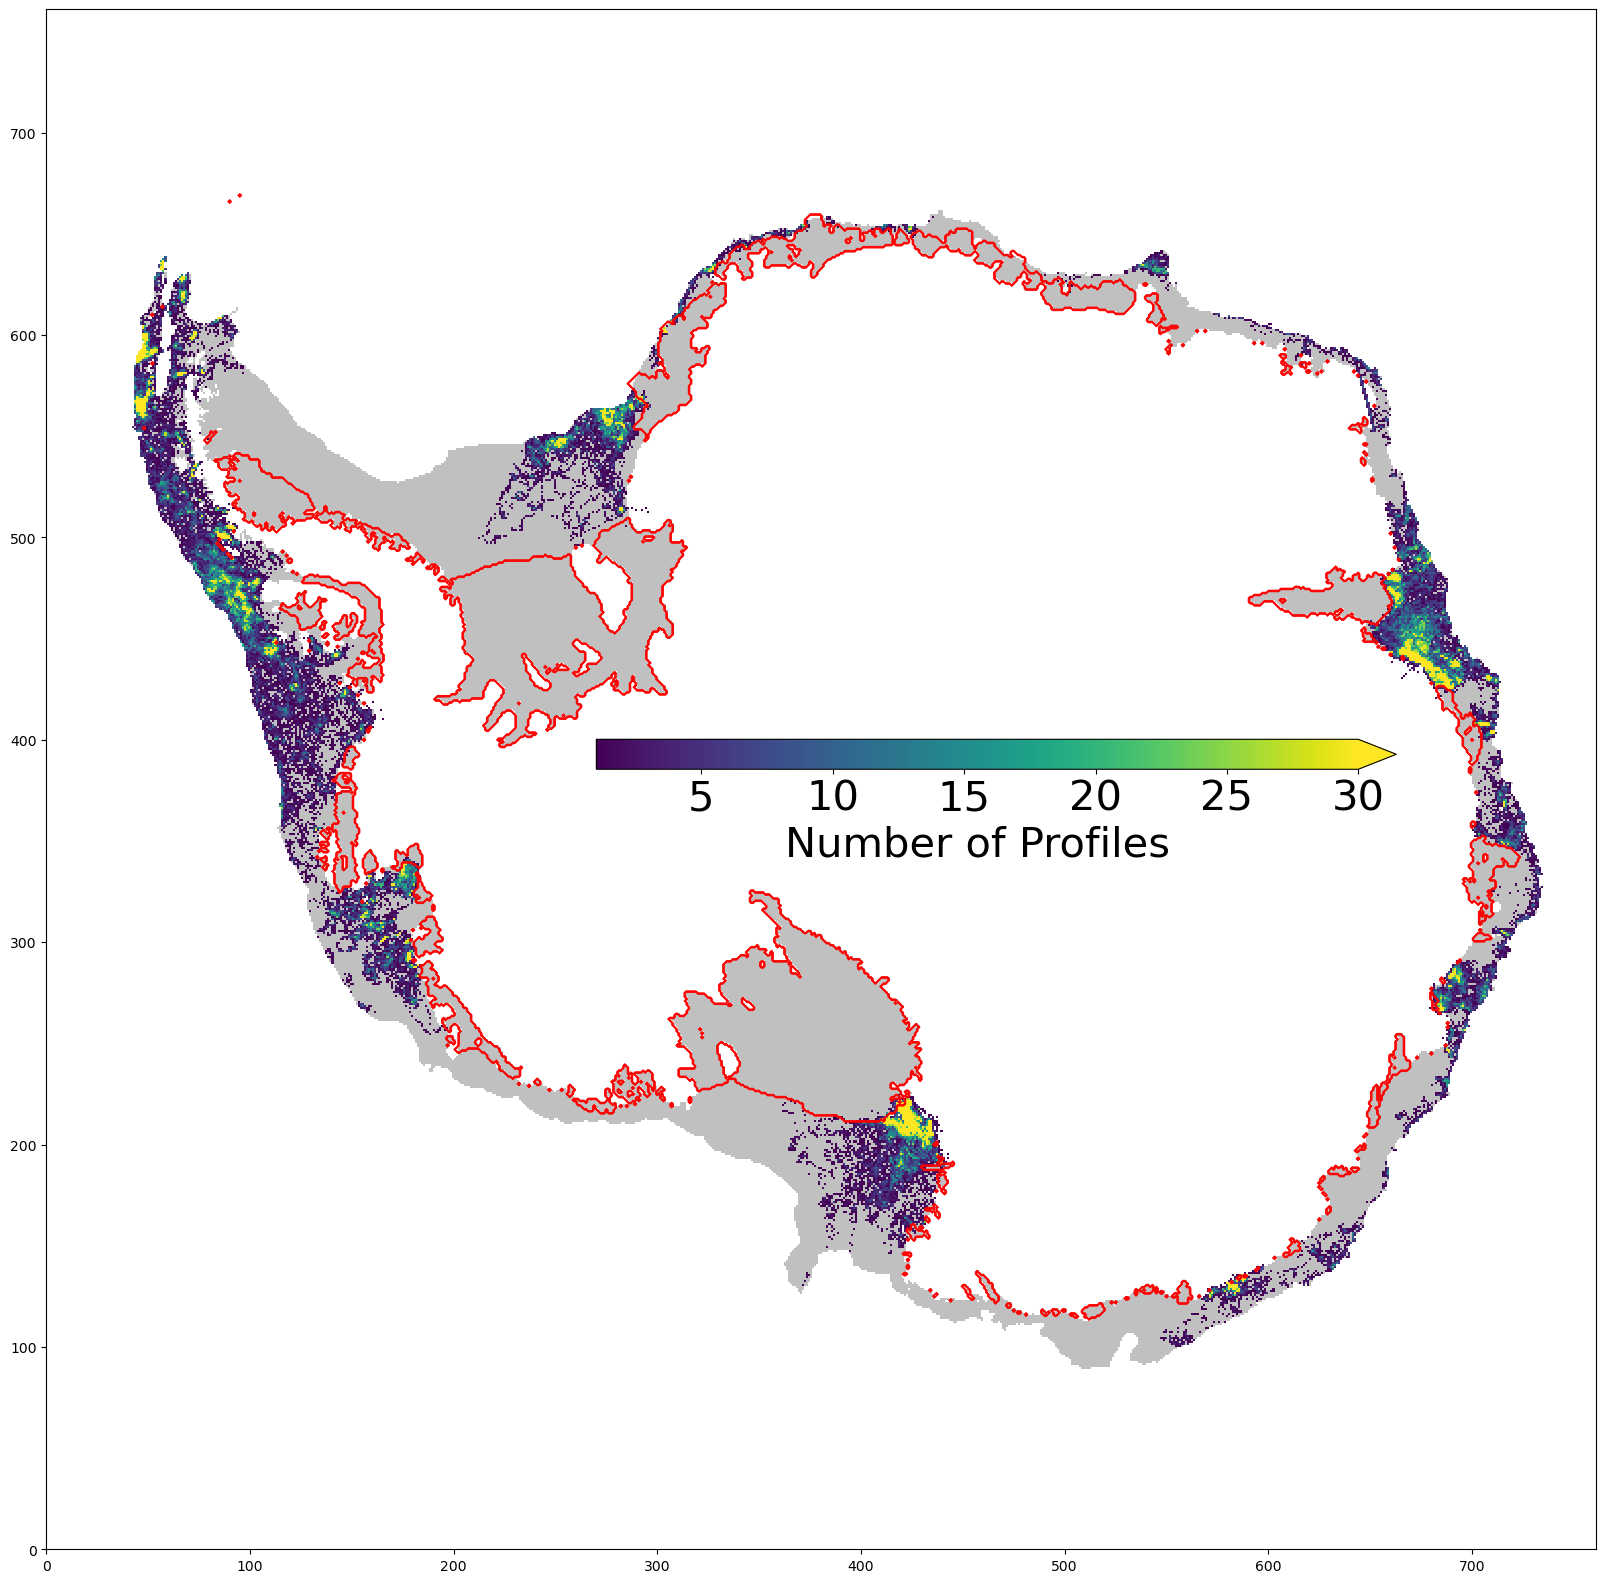

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
ax.pcolormesh(cs_mask, alpha=1, cmap='gray', vmin=-2, vmax=2)
im = ax.pcolormesh(density, vmin=1, vmax=30, zorder=2)

# ax.pcolormesh(Region_Mask, alpha=1)
ax.contour(ICESHELVES, colors=['red'], linewidths=0.5)

cbar_ax = fig.add_axes([0.4, 0.5, 0.4, 0.015])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='max')
cbar.ax.set_xlabel(f'Number of Profiles', size=30)
cbar.ax.tick_params(labelsize=30) 
cbar.ax.set_xticks([5, 10 ,15, 20, 25, 30])

plt.savefig('img2_regions/Density.png', dpi=300)